# Importing Packages


In [1]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------

# Standard library
import os
import glob
import math
import re
import shutil
import time
import json
import warnings

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import EdgeConv, knn_graph, global_max_pool


# PyTorch Ignite
from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ignite.metrics.metric import Metric
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger

# Warnings
warnings.filterwarnings("ignore")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
cudnn.deterministic = True
cudnn.benchmark = False


print(torch.__version__)     # e.g., 2.1.0
print(torch.version.cuda) 


2.5.1
11.8


c:\Users\absaa\anaconda3\envs\torch-gpu-copy\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
C:\Windows\Temp\ipykernel_13788\3892951699.py:44: DeprecationWarning: c:\Users\absaa\anaconda3\envs\torch-gpu-copy\lib\site-packages\ignite\contrib\handlers\tensorboard_logger.py has been moved to /ignite/handlers/tensorboard_logger.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger


In [2]:
# -----------------------------
# PyG Extension Sanity Check
# -----------------------------
try:
    import torch_scatter
    import torch_sparse
    import torch_cluster
    import torch_spline_conv
    from torch_geometric.nn import knn_graph

    # Create dummy inputs
    x = torch.randn(32, 3).cuda()  # 32 3D points
    batch = torch.zeros(32, dtype=torch.long).cuda()
    edge_index = knn_graph(x, k=4, batch=batch)

    print("✅ PyG extensions loaded and working.")
except ImportError as e:
    print("❌ PyG Import Error:", e)
except Exception as e:
    print("❌ PyG Runtime Error:", e)


✅ PyG extensions loaded and working.


# EDA

In [3]:
df = pd.read_csv('..\data\DrivAerNetPlusPlus_Drag_8k_cleaned.csv')
df.describe()

,Average Cd
count,7713.000000
mean,0.284412
std,0.037232
min,0.201138
25%,0.255859
50%,0.282987
75%,0.311521
max,0.383330


In [4]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# Get current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


CUDA Available: True
Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 0.0029296875 MB
Memory Cached: 2.0 MB


<Axes: xlabel='Average Cd', ylabel='Count'>

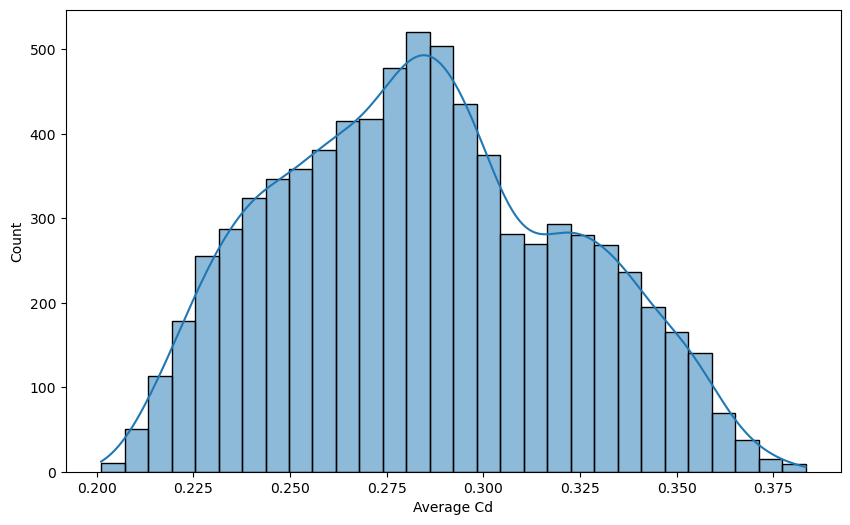

In [5]:
# Plot the pdf graph for Average Drag Coefficient (Cd)
plt.figure(figsize=(10, 6))
sns.histplot(df['Average Cd'], bins=30, kde=True)

# Pepraring Scaler Function and Global variables

In [6]:
# -----------------------------
# 1.2. Prepaing Scaler
# -----------------------------

# Subset to only training car IDs
with open("../data/subset_dir/train_design_ids.txt") as f:
    train_ids = [line.strip() for line in f]

df_train = df[df["Design"].isin(train_ids)]
scaler = StandardScaler()
scaler.fit(df_train[["Average Cd"]])

print(f"Scaler mean: {scaler.mean_[0]:.6f}, std: {scaler.scale_[0]:.6f}")

# Save scaler to disk
os.makedirs("../outputs", exist_ok=True)
joblib.dump(scaler, "../outputs/cd_scaler.pkl")

Scaler mean: 0.284506, std: 0.037448


['../outputs/cd_scaler.pkl']

In [7]:
# -----------------------------
# 1.3. Global Variables
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4

model_checkpoint_dir="../outputs/checkpointsTransformer"
analysis_output_dir='../outputs/analysisTransformer'

scaler = joblib.load("../outputs/cd_scaler.pkl")



# Model

In [8]:
# ###################################
# Attention Pooling PointNet2D
# ###################################
class PointNet2D(nn.Module):
    def __init__(
        self, 
        input_dim=2, 
        emb_dim=256
    ):
        super(PointNet2D, self).__init__()

        self.mlp = nn.Sequential(
            nn.Conv1d(input_dim, 64, 1),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, 1),
            nn.LeakyReLU(),
            nn.Conv1d(128, emb_dim, 1),
            nn.LeakyReLU()
        )

        # Attention layer: produces (B, 1, N)
        self.attn = nn.Conv1d(emb_dim, 1, 1)

    def forward(self, x, mask=None):
        # x: (B, N, 2)
        x = x.transpose(1, 2)  # (B, 2, N)

        features = self.mlp(x)  # (B, emb_dim, N)

        # Compute attention weights
        attn_logits = self.attn(features)  # (B, 1, N)
        
        
        # Masking
        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, N)
            attn_logits = attn_logits.masked_fill(mask == 0, float('-inf'))

        attn_weights = torch.softmax(attn_logits, dim=2)  # (B, 1, N)

        # Apply attention weights
        embedding = torch.sum(features * attn_weights, dim=2)  # (B, emb_dim)

        return embedding

In [9]:
# ###################################
# Minimal EdgeConv Slice Encoder (Replaces PointNet2D)
# ###################################
class EdgeConvSliceEncoder(nn.Module):
    """
    Encodes a batch of 2D slices, each with a variable number of points,
    into a fixed-size embedding vector for each slice.
    This module is designed to work with PyTorch Geometric's Batch object.
    """
    def __init__(self, input_dim=2, emb_dim=256, k=20):
        super().__init__()
        self.k = k

        # Define the MLP that will be used inside EdgeConv
        # It processes concatenated features of a point and its neighbors
        mlp = nn.Sequential(
            nn.Linear(2 * input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, emb_dim) # Output the final embedding dimension
        )

        # The EdgeConv layer itself
        self.edge_conv = EdgeConv(nn=mlp, aggr='max')

    def forward(self, data):
        """
        Processes a PyG Batch object representing multiple slices.
        Args:
            data (torch_geometric.data.Batch): A batch of slices, containing:
                - data.x (Tensor): All points from all slices concatenated [N_total_points, 2].
                - data.batch (Tensor): A tensor mapping each point to its original slice
                                    in the batch [N_total_points].
        Returns:
            Tensor: A tensor of shape [num_slices_in_batch, emb_dim].
        """
        # 1. Dynamically build the k-NN graph for the current set of points.
        #    `knn_graph` is batch-aware and will not connect points from different slices.
        edge_index = knn_graph(data.x, k=self.k, batch=data.batch)

        # 2. Apply the EdgeConv layer to learn features for each point.
        point_features = self.edge_conv(data.x, edge_index)

        # 3. Use global max pooling to get ONE fixed-size vector per slice.
        #    `global_max_pool` is also batch-aware.
        slice_embedding = global_max_pool(point_features, data.batch)

        return slice_embedding

In [10]:
# ################################
# Attention Pooling Transformer Encoder
# ################################
# --- Your helper function (define this once outside the class) ---
def generate_sinusoidal_position_embeddings(max_seq_len, embedding_dim):
    pe = torch.zeros(max_seq_len, embedding_dim)
    position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0) # Add batch dimension for (1, S, D)

# --- Your TransformerSliceEncoder class ---
class TransformerSliceEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 256, 
        hidden_dim: int = 256,
        num_layers: int = 2,
        nhead: int = 1,
        dropout: float = 0.1,
        max_seq_len: int = 80, # Fixed at 80
    ):
        super().__init__()
        # KEY CHANGE 1: Use the pre-calculated sinusoidal embeddings
        # We register it as a buffer so it's moved to GPU with the model,
        # but NOT optimized by the optimizer (fixed).
        self.register_buffer(
            'pos_encoder',
            generate_sinusoidal_position_embeddings(max_seq_len, input_dim)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True,
            activation="relu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.attn_pool = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, src_key_padding_mask: torch.Tensor = None):
        """
        x: (B, S, D)
        src_key_padding_mask: (B, S) mask with True = pad, False = valid
        """
        B, S, D = x.shape
        # KEY CHANGE 2: No change here, the addition logic remains the same.
        # Now, self.pos_encoder contains fixed, meaningful position info.
        x = x + self.pos_encoder[:, :S, :]

        out = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

        # Attention pooling
        scores = self.attn_pool(out).squeeze(-1)  # (B, S)
        
        if src_key_padding_mask is not None:
            scores = scores.masked_fill(src_key_padding_mask, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)  # (B, S)
        pooled = torch.sum(attn_weights.unsqueeze(-1) * out, dim=1)  # (B, D)

        return self.dropout(pooled)


In [11]:
# ################################
# Regression Model for Cd
# ################################

class CdRegressor(nn.Module):
    def __init__(self, input_dim=256):  
        """
        A simple regression model to predict the average drag coefficient (Cd) from the output of the TransformerSliceEncoder.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(), 
            nn.Linear(128, 1)  # Output layer for regression
        )

    def forward(self, x):
        """
        x: (B, input_dim)
        returns: (B,)
        """
        return self.net(x).squeeze(1)


In [12]:
# ORIGINAL PREDICTOR NET


# class CdPredictorNet(nn.Module):
#     def __init__(self, pointnet, transformer_encoder, regressor):
#         super().__init__()
#         self.pointnet = pointnet
#         self.transformer_encoder = transformer_encoder
#         self.regressor = regressor

#     def forward(self, slices, point_mask, slice_mask=None):
#         """
#         slices: (B, S, N, D) — batch of S slices, N points each, D = 2 (xy)
#         point_mask: (B, S, N) — mask for points (1 for valid, 0 for padded)
#         slice_mask: (B, S) — mask for slices (optional, 1 valid / 0 padded)
#         """
#         B, S, N, D = slices.shape

#         # Flatten slices for PointNet
#         flat_slices = slices.view(B * S, N, D)         # (B*S, N, D)
#         flat_mask = point_mask.view(B * S, N)          # (B*S, N)

#         # PointNet: (B*S, N, D) -> (B*S, emb_dim)
#         slice_embs = self.pointnet(flat_slices, flat_mask)  
#         slice_embs = slice_embs.view(B, S, -1)         # (B, S, emb_dim)

#         # Transformer Encoder: (B, S, emb_dim) -> (B, final_emb_dim)
#         car_emb = self.transformer_encoder(slice_embs)

#         # Regression head
#         return self.regressor(car_emb)


In [13]:
# PREDICTOR NET FOR EXPERIMENTING EDGE CONV
class CdPredictorNet(nn.Module):
    def __init__(self, slice_encoder, transformer_encoder, regressor):
        super().__init__()
        self.slice_encoder = slice_encoder
        self.transformer_encoder = transformer_encoder
        self.regressor = regressor

    def forward(self, car_slice_batches):
        """
        Args:
            car_slice_batches (list of torch_geometric.data.Batch):
                A list of length 80. Each element is a PyG Batch object
                representing all slices at that index from the main training batch.
        """
        device = next(self.parameters()).device
        slice_embeddings = []

        for slice_batch in car_slice_batches:
            slice_batch = slice_batch.to(device)
            embedding = self.slice_encoder(slice_batch)
            slice_embeddings.append(embedding)

        transformer_input = torch.stack(slice_embeddings, dim=0)
        transformer_input = transformer_input.transpose(0, 1)

        car_emb = self.transformer_encoder(transformer_input)

        return self.regressor(car_emb)

# Dataset loader and Model Summary

In [14]:
# -----------------------------
# 6. Dataset Loader
# -----------------------------
class CarSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, ids_txt, npz_dir, csv_path, max_cars=None, scaler = None):
        """
        Args:
            ids_txt (str): Path to the text file containing car IDs.
            npz_dir (str): Directory containing the .npz files.
            csv_path (str): Path to the CSV file with Cd values.
            max_cars (int, optional): Limit the number of cars to load. Defaults to None.
            scaler (object, optional): Scaler object for normalizing Cd values. Defaults to None.
        """
        self.car_ids = [line.strip() for line in open(ids_txt)]
        if max_cars:
            self.car_ids = self.car_ids[:max_cars]
        self.npz_dir = npz_dir
        self.cd_map = pd.read_csv(csv_path).set_index("Design")["Average Cd"].to_dict()
        self.scaler = scaler if scaler else None

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        
        car_id = self.car_ids[idx]
        data = np.load(os.path.join(self.npz_dir, f"{car_id}_axis-x.npz"))

        # Keep in NumPy for now (better for pin_memory and batch collation)
        slices = data["slices"].astype(np.float32)         # (80, 6500, 2)
        point_mask = data["point_mask"].astype(np.float32) # (80, 6500)
        slice_mask = data["slice_mask"].astype(np.float32) # (80,)
        cd_value = np.float32(self.cd_map[car_id])

        if self.scaler:
            cd_value = self.scaler.transform([[cd_value]])[0, 0]

        return slices, point_mask, slice_mask, cd_value


In [15]:
# DATA LOADER DIRECT SLICES
# ################################
# New Dataset for Raw Slices (Replaces CarSlicesDataset)
# ################################
class CarSlicesDataset_PyG(torch.utils.data.Dataset):
    def __init__(self, ids_txt, raw_npy_dir, csv_path, scaler=None):
        """
        Args:
            ids_txt (str): Path to the text file containing car IDs.
            raw_npy_dir (str): Directory containing the RAW .npy files (object arrays).
            csv_path (str): Path to the CSV file with Cd values.
            scaler (object, optional): Scaler for normalizing Cd values.
        """
        self.car_ids = [line.strip() for line in open(ids_txt)]
        self.raw_npy_dir = raw_npy_dir
        self.cd_map = pd.read_csv(csv_path).set_index("Design")["Average Cd"].to_dict()
        self.scaler = scaler

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        car_id = self.car_ids[idx]
        raw_slices = np.load(os.path.join(self.raw_npy_dir, f"{car_id}_axis-x.npy"), allow_pickle=True)
        cd_value = np.float32(self.cd_map[car_id])

        slice_data_list = [
            Data(x=torch.from_numpy(s.astype(np.float32))) for s in raw_slices
        ]

        if self.scaler:
            cd_value = self.scaler.transform([[cd_value]])[0, 0]

        return slice_data_list, cd_value

# ################################
# New Collate Function for the DataLoader
# ################################
# Simplified Collate Function
def collate_fn_pyg(batch):
    car_data_list, cd_list = zip(*batch)
    slices_by_index = zip(*car_data_list)
    batched_slices = [Batch.from_data_list(slice_list) for slice_list in slices_by_index]
    cd_values = torch.tensor(cd_list, dtype=torch.float32)
    return batched_slices, cd_values

In [16]:
# ###################################
# SliceEdgeNet: A Deeper, Dynamic Slice Encoder
# ###################################
class SliceEdgeNet(nn.Module):
    """
    A 2-layer dynamic graph CNN to learn rich geometric features from 2D slices.
    """
    def __init__(self, input_dim=2, emb_dim=256, k=16):
        super().__init__()
        self.k = k

        # First convolutional layer: Learns basic geometric primitives.
        # Takes raw coordinates (dim=2*2=4) and outputs 64-dim features.
        mlp1 = nn.Sequential(
            nn.Linear(2 * input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.conv1 = EdgeConv(nn=mlp1, aggr='max')

        # Second convolutional layer: Learns higher-order motifs from the first layer's features.
        # Takes concatenated 64-dim features (dim=2*64=128) and outputs the final embedding dim.
        mlp2 = nn.Sequential(
            nn.Linear(2 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, emb_dim)
        )
        self.conv2 = EdgeConv(nn=mlp2, aggr='max')

    def forward(self, data):
        """
        Processes a PyG Batch object.
        """
        # --- First Layer ---
        # Graph is built on spatial coordinates (data.x)
        edge_index1 = knn_graph(data.x, k=self.k, batch=data.batch)
        # Output x1 has shape [N_total_points, 64]
        x1 = self.conv1(data.x, edge_index1)

        # --- Second Layer (The "Dynamic" Part) ---
        # The new graph is built on the FEATURE SPACE (x1) from the first layer.
        # This allows the model to group points that have similar geometric roles.
        edge_index2 = knn_graph(x1, k=self.k, batch=data.batch)
        # Output x2 has shape [N_total_points, 256]
        x2 = self.conv2(x1, edge_index2)

        # --- Final Global Pooling ---
        # Aggregate all the rich point features into one vector per slice.
        slice_embedding = global_max_pool(x2, data.batch)
        
        return slice_embedding

In [17]:
# from torchinfo import summary
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pointnet = PointNet2D()
# encoder = TransformerSliceEncoder()
# regressor = CdRegressor()
# model = CdPredictorNet(pointnet, encoder, regressor).to(device)

# summary(
#     model,
#     input_data=[
#         torch.zeros(batch_size, 80, 6500, 2).to(device),   # pointnet input
#         torch.ones(batch_size, 80, 6500).to(device),       # mask?
#         torch.ones(batch_size, 80).to(device)              # maybe slice mask?
#     ]
# )

# Training Loop

In [18]:
# Custom RMSE metric
class RMSE(Metric):
    def reset(self):
        self._sum_squared_error = 0.0
        self._num_examples = 0

    def update(self, output):
        y_pred, y = output
        errors = (y_pred - y) ** 2
        self._sum_squared_error += torch.sum(errors).item()
        self._num_examples += y.shape[0]

    def compute(self):
        return (self._sum_squared_error / self._num_examples) ** 0.5

# Custom R² metric
class R2Score(Metric):
    def reset(self):
        self._y_true = []
        self._y_pred = []

    def update(self, output):
        y_pred, y = output
        self._y_pred.extend(y_pred.detach().cpu().numpy().flatten())
        self._y_true.extend(y.detach().cpu().numpy().flatten())

    def compute(self):
        return r2_score(self._y_true, self._y_pred)

# Create training engine
# def create_trainer(model, optimizer, loss_fn, device, accumulation_steps):
#     def _update(engine, batch):
#         model.train()
#         slices, point_mask, slice_mask, cd_gt = [b.to(device) for b in batch]
#         optimizer.zero_grad()
#         with torch.amp.autocast("cuda"):
#             pred = model(slices, point_mask, slice_mask)
#             # scale loss for accumulation
#             loss = loss_fn(pred, cd_gt.float()) / accumulation_steps
#         loss.backward()
#         if (engine.state.iteration % accumulation_steps) == 0:
#             optimizer.step()
#             optimizer.zero_grad()
#         return pred, cd_gt
#     return Engine(_update)

# # Create evaluation engine
# def create_evaluator(model, loss_fn, device):
#     def _inference(engine, batch):
#         model.eval()
#         with torch.no_grad():
#             slices, point_mask, slice_mask, cd_gt = [b.to(device) for b in batch]
#             with torch.amp.autocast("cuda"):
#                 pred = model(slices, point_mask, slice_mask)
#         return pred, cd_gt

#     return Engine(_inference)

# --- MODIFIED: Create training engine ---
def create_trainer(model, optimizer, loss_fn, device, accumulation_steps):
    def _update(engine, batch):
        model.train()
        # NEW: Unpack the simplified batch format
        car_slice_batches, cd_gt = batch
        cd_gt = cd_gt.to(device) # Move only the GT tensor to the device here

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            # NEW: Pass only the list of batches to the model
            pred = model(car_slice_batches)
            loss = loss_fn(pred, cd_gt.float()) / accumulation_steps
        loss.backward()
        if (engine.state.iteration % accumulation_steps) == 0:
            optimizer.step()
            optimizer.zero_grad()
        return pred, cd_gt
    return Engine(_update)

# --- MODIFIED: Create evaluation engine ---
def create_evaluator(model, loss_fn, device):
    def _inference(engine, batch):
        model.eval()
        with torch.no_grad():
            # NEW: Unpack the simplified batch format
            car_slice_batches, cd_gt = batch
            cd_gt = cd_gt.to(device) # Move only the GT tensor to the device here
            with torch.amp.autocast("cuda"):
                # NEW: Pass only the list of batches to the model
                pred = model(car_slice_batches)
        return pred, cd_gt

    return Engine(_inference)

# Attach metrics to an engine
def attach_metrics(engine, loss_fn):
    Loss(loss_fn).attach(engine, "loss")
    RMSE().attach(engine, "rmse")
    R2Score().attach(engine, "r2")


In [19]:
# 
def train_model(
    resume: bool = True,
    delete_previous_model_dir: bool = False,
    num_epochs: int = 50,
    batch_size: int = 1,
    learning_rate: float = 1e-4,
    accumulation_steps: int = 32,
    early_stopping_patience: int = 5,
    model_dir: str = "./model_dir",

    # Dataset configuration
    training_set_size: int = None,
    validation_set_size: int = None,
    train_ids_txt: str = "../data/subset_dir/train_design_ids.txt",
    val_ids_txt: str = "../data/subset_dir/val_design_ids.txt",
    # npz_dir: str = "../outputs/pad_masked_slices",
    # --- MODIFIED: Point to the RAW .npy directory ---
    raw_npy_dir: str = "../outputs/slices",
    csv_path: str = "../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
    scaler=None,

    # # Model hyperparameters
    # point_net_input_dim: int = 2,
    # point_net_embedding_dim: int = 256,
    # Model hyperparameters
    # --- NEW: Hyperparameter for EdgeConv ---
    k_neighbors: int = 20,
    slice_embedding_dim: int = 256,
    transformer_hidden_dim: int = 256,
    transformer_num_layers: int = 2,
    transformer_nhead: int = 1,
    cd_regressor_input_dim: int = 256,
):
    checkpoints_dir = os.path.join(model_dir, "checkpoints")
    results_dir = os.path.join(model_dir, "results")
    os.makedirs(checkpoints_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    # 1) Optional cleanup
    if delete_previous_model_dir and not resume:
        if os.path.isdir(model_dir) and os.listdir(model_dir):
            confirm = input(f"[WARN] Contents found in '{model_dir}'. Delete all contents? (yes/no): ").strip().lower()
            if confirm == "yes":
                # Delete all contents inside model_dir
                for entry in os.scandir(model_dir):
                    if entry.is_dir():
                        shutil.rmtree(entry.path)
                    else:
                        os.remove(entry.path)
                print(f"[INFO] All contents of '{model_dir}' have been deleted.")
            else:
                print("[INFO] Cleanup aborted by user.")
        else:
            print(f"[INFO] Nothing to clean. '{model_dir}' is empty or does not exist.")


    # # 2) Model setup
    # pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    # encoder = TransformerSliceEncoder(input_dim=point_net_embedding_dim, hidden_dim=transformer_hidden_dim, num_layers=transformer_num_layers, nhead=transformer_nhead)
    # regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    # model = CdPredictorNet(pointnet, encoder, regressor).to(device)
    
    # --- MODIFIED: Model setup ---
    print(f"[INFO] Setting up model with k={k_neighbors} for EdgeConv...")
    slice_encoder = EdgeConvSliceEncoder(input_dim=2, emb_dim=slice_embedding_dim, k=k_neighbors)
    # print(f"[INFO] Setting up model with SliceEdgeNet (k={k_neighbors})...")
    # slice_encoder = SliceEdgeNet(input_dim=2, emb_dim=slice_embedding_dim, k=k_neighbors)
    encoder = TransformerSliceEncoder(input_dim=slice_embedding_dim, hidden_dim=transformer_hidden_dim, num_layers=transformer_num_layers, nhead=transformer_nhead)
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    model = CdPredictorNet(slice_encoder, encoder, regressor).to(device)


    print(model)
    print(f"[INFO] Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # 3) Training components
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # --- ADD THIS: The Scheduler ---
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)
    # We will monitor Validation Loss, so mode='min'
    # factor=0.2: Reduce LR by a factor of 5 when triggered.
    # patience=3: Wait 3 epochs with no improvement in Val_loss before reducing LR.
    
    loss_fn = nn.SmoothL1Loss()
    trainer = create_trainer(model, optimizer, loss_fn, device, accumulation_steps)
    evaluator = create_evaluator(model, loss_fn, device)
    attach_metrics(trainer, loss_fn)
    attach_metrics(evaluator, loss_fn)

    train_pbar = ProgressBar(persist=True, desc="Training")
    train_pbar.attach(trainer, metric_names=["loss", "rmse", "r2"])
    val_pbar = ProgressBar(persist=True, desc="Validation")
    val_pbar.attach(evaluator, metric_names=["loss", "rmse", "r2"])

    # # 4) Data
    # train_loader = torch.utils.data.DataLoader(
    #     CarSlicesDataset(train_ids_txt, npz_dir, csv_path, training_set_size, scaler),
    #     batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(
    #     CarSlicesDataset(val_ids_txt, npz_dir, csv_path, validation_set_size, scaler),
    #     batch_size=batch_size * 2, shuffle=False)

    # --- MODIFIED: Data setup ---
    print(f"[INFO] Loading data from raw npy directory: {raw_npy_dir}")
    train_dataset = CarSlicesDataset_PyG(train_ids_txt, raw_npy_dir, csv_path, scaler)
    val_dataset = CarSlicesDataset_PyG(val_ids_txt, raw_npy_dir, csv_path, scaler)

    train_loader = PyGDataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_pyg,
    )
    val_loader = PyGDataLoader(
        val_dataset,
        batch_size=batch_size * 2,
        shuffle=False,
        collate_fn=collate_fn_pyg,
    )

    # 5) TensorBoard
    tb_logger = TensorboardLogger(log_dir=os.path.join(checkpoints_dir, "logs"))
    for tag, engine in [("training", trainer), ("validation", evaluator)]:
        tb_logger.attach_output_handler(engine, Events.EPOCH_COMPLETED, tag, metric_names=["loss", "rmse", "r2"])

    # 6) Resume
    start_epoch = 1
    if resume:
        ckpts = sorted(glob.glob(os.path.join(checkpoints_dir, "epoch_*.pt")))
        if ckpts:
            last_ckpt = ckpts[-1]
            print(f"[INFO] Resuming from checkpoint: {os.path.basename(last_ckpt)}")
            data = torch.load(last_ckpt, map_location=device)
            model.load_state_dict(data["model"])
            optimizer.load_state_dict(data["optimizer"])
            start_epoch = data.get("epoch", 1) + 1
        else:
            print("[INFO] No checkpoint found. Starting fresh.")

    # 7) Best model saving
    evaluator.add_event_handler(Events.COMPLETED, ModelCheckpoint(
        dirname=checkpoints_dir,
        filename_prefix="best_model",
        n_saved=1,
        score_function=lambda eng: eng.state.metrics["r2"],
        score_name="r2",
        global_step_transform=lambda eng, _: eng.state.epoch + start_epoch - 1,
        require_empty=False
    ), {"model": model})

    # 8) Early stopping
    evaluator.add_event_handler(Events.COMPLETED, EarlyStopping(
        patience=early_stopping_patience,
        score_function=lambda eng: eng.state.metrics["r2"],
        trainer=trainer
    ))

    # 9) Load previous history if exists
    history_path = os.path.join(results_dir, "training_history.json")
    new_history = []
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            new_history = json.load(f)
    else:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(history_path), exist_ok=True)

    # 10) Validation handler
    @trainer.on(Events.EPOCH_COMPLETED)
    def validate(engine):
        evaluator.run(val_loader)
        epoch_num = engine.state.epoch + start_epoch - 1
        train_metrics = engine.state.metrics
        # --- ADD THIS: Tell the scheduler to step ---
        scheduler.step(val_metrics['loss'])
        val_metrics = evaluator.state.metrics

        record = {
            "epoch": epoch_num,
            "Train_loss": train_metrics["loss"],
            "Train_rmse": train_metrics["rmse"],
            "Train_r2": train_metrics["r2"],
            "Val_loss": val_metrics["loss"],
            "Val_rmse": val_metrics["rmse"],
            "Val_r2": val_metrics["r2"],
        }
        new_history.append(record)

        print(f"\n[Epoch {epoch_num:03d}] ------------------------")
        for key, value in record.items():
            if key != "epoch":
                print(f"{key:17}: {value:.6f}" if isinstance(value, float) else f"{key:17}: {value}")

        with open(history_path + ".bak", "w") as f:
            json.dump(new_history, f, indent=2)
        with open(history_path, "w") as f:
            json.dump(new_history, f, indent=2)

        torch.save({
            "epoch": epoch_num,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, os.path.join(checkpoints_dir, f"epoch_{epoch_num:03d}_loss_{val_metrics['loss']:.8f}.pt"))

    # 11) Run training
    try:
        trainer.run(train_loader, max_epochs=num_epochs - start_epoch + 1)
    except KeyboardInterrupt:
        print("\n⛔ Training interrupted by user.")
    finally:
        tb_logger.close()
        best_ckpt = sorted(glob.glob(os.path.join(checkpoints_dir, "best_model_*.pt")))
        if best_ckpt:
            print(f"[INFO] Loading best model from: {os.path.basename(best_ckpt[-1])}")
            best_model_data = torch.load(best_ckpt[-1], map_location=device)
            model.load_state_dict(best_model_data["model"] if "model" in best_model_data else best_model_data)

        with open(history_path, "r") as f:
            final_history = json.load(f)
        return model, final_history


# Training Model

In [20]:
# Directories
model_dir = "../model_outputs/DTM256_Model"
checkpoints_dir = os.path.join(model_dir, "checkpoints")
results_dir = os.path.join(model_dir, "results")
os.makedirs(checkpoints_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

os.makedirs
# History file paths
json_history_path = os.path.join(results_dir, "training_history.json")

# Call the training function
model, _ = train_model(
    # General training configuration
    resume=False,
    delete_previous_model_dir=True,
    num_epochs=100,
    batch_size=4,
    learning_rate=1e-4,
    accumulation_steps=1,
    early_stopping_patience=8,
    model_dir = model_dir,

    # Dataset configuration
    training_set_size= None,
    validation_set_size= None,
    train_ids_txt="../data/subset_dir/train_design_ids.txt",
    val_ids_txt="../data/subset_dir/val_design_ids.txt",
    # npz_dir="../outputs/pad_masked_slices",
    # --- MODIFIED: Dataset configuration ---
    raw_npy_dir="../outputs/slices", # UPDATE THIS to your raw .npy file directory
    csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
    scaler=scaler,

    # Model hyperparameters
    # point_net_input_dim=2,
    # point_net_embedding_dim=256,
    # --- MODIFIED: Model hyperparameters ---
    k_neighbors=16, # The new hyperparameter for EdgeConv
    slice_embedding_dim=256,
    transformer_hidden_dim=256,
    transformer_num_layers=4,
    transformer_nhead=4,
    cd_regressor_input_dim=256,
)

# Load Json history and convert to DataFrame and print
history_df = pd.read_json(json_history_path)
print(history_df.head())

[INFO] All contents of '../model_outputs/DTM256_Model' have been deleted.
[INFO] Setting up model with k=16 for EdgeConv...
CdPredictorNet(
  (slice_encoder): EdgeConvSliceEncoder(
    (edge_conv): EdgeConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
    ))
  )
  (transformer_encoder): TransformerSliceEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNo

Training[1/1350]   0%|           [00:00<?]

Validation[1/145]   1%|           [00:00<?]

Engine run is terminating due to exception: local variable 'val_metrics' referenced before assignment


[INFO] Loading best model from: best_model_model_1_r2=-0.0131.pt


FileNotFoundError: [Errno 2] No such file or directory: '../model_outputs/DTM256_Model\\results\\training_history.json'

# Evaluation

In [ ]:
import os
import glob
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_all_checkpoints(checkpoint_dir="../outputs/temp_checkpoints", output_dir="../outputs/temp_analysis"):
    os.makedirs(output_dir, exist_ok=True)
    
    checkpoint_paths = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")))
    all_epoch_losses = []
    epoch_numbers = []

    print("\n📋 Epoch-wise Loss Summary:")
    for ckpt_path in checkpoint_paths:
        try:
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            losses = checkpoint.get("epoch_losses", [])
            epoch = checkpoint.get("epoch", None)

            if epoch is not None and losses:
                epoch_numbers.append(epoch)
                last_loss = losses[-1]
                all_epoch_losses.append(last_loss)
                print(f"Epoch {epoch:02d} → Loss: {last_loss:.7f}")

        except Exception as e:
            print(f"⚠️ Skipped {ckpt_path}: {e}")

    if not epoch_numbers:
        print("❌ No valid checkpoints found.")
        return

    # Save compiled loss log
    loss_log_path = os.path.join(output_dir, "compiled_epoch_losses.json")
    with open(loss_log_path, "w") as f:
        json.dump({
            "epoch_numbers": epoch_numbers,
            "epoch_losses": all_epoch_losses
        }, f, indent=2)
    print(f"\n📄 Saved compiled loss log to: {loss_log_path}")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=epoch_numbers, y=all_epoch_losses, marker="o")
    plt.title("📉 Training Loss Curve from Checkpoints")
    plt.xlabel("Epoch")
    plt.ylabel("SmoothL1 Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_curve_from_ckpts.png"))
    plt.close()

    # Plot deltas
    if len(all_epoch_losses) > 1:
        loss_deltas = [all_epoch_losses[i] - all_epoch_losses[i-1] for i in range(1, len(all_epoch_losses))]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=epoch_numbers[1:], y=loss_deltas)
        plt.title("📊 Δ Loss Between Checkpoints")
        plt.xlabel("Epoch")
        plt.ylabel("Δ Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "loss_deltas_from_ckpts.png"))
        plt.close()

    print(f"✅ Done analyzing {len(epoch_numbers)} checkpoints")

In [ ]:
analyze_all_checkpoints(checkpoint_dir=model_checkpoint_dir, output_dir=analysis_output_dir) 

In [ ]:
def load_best_model(model_checkpoint_dir, k_neighbors=20, slice_embedding_dim=256):
    """
    Loads the best model saved by the trainer.

    Args:
        model_checkpoint_dir (str): Path to the directory containing checkpoints.
        k_neighbors (int): The 'k' value used for EdgeConv during training.
        slice_embedding_dim (int): The embedding dimension of the slice encoder.
    """
    # Find the best model file. Note: The name might vary based on ignite's saving.
    # Let's search for any file starting with "best_model".
    best_model_paths = glob.glob(os.path.join(model_checkpoint_dir, "best_model_*.pt"))
    if not best_model_paths:
        print(f"❌ No best_model file found at: {model_checkpoint_dir}")
        return None
    
    best_model_path = best_model_paths[0] # Assume the first match is the one we want

    # --- MODIFIED: Recreate the NEW model architecture ---
    print(f"[INFO] Recreating model with k={k_neighbors} to load best checkpoint...")
    slice_encoder = EdgeConvSliceEncoder(input_dim=2, emb_dim=slice_embedding_dim, k=k_neighbors)
    # Ensure these Transformer/Regressor params match your training call
    encoder = TransformerSliceEncoder(
        input_dim=slice_embedding_dim,
        hidden_dim=256,
        num_layers=4,
        nhead=4,
    )
    regressor = CdRegressor(input_dim=slice_embedding_dim)
    best_model = CdPredictorNet(slice_encoder, encoder, regressor).to(device)

    # Load the state dictionary
    # The saved object from ModelCheckpoint is just the state_dict
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()
    print(f"🏆 Loaded best model from: {os.path.basename(best_model_path)}")

    return best_model

In [ ]:
# def load_best_model(model_checkpoint_dir = model_checkpoint_dir):
#     """
#     Loads the best model saved in `best_model.pt` using global architecture settings.
#     """
#     best_model_path = os.path.join(model_checkpoint_dir, "best_model.pt")

#     # Recreate model architecture using global config
#     pointnet = PointNet2D(input_dim = 2, emb_dim=256)
#     encoder = TransformerSliceEncoder(
#         input_dim=256,
#         hidden_dim=256,
#         num_layers=4,
#         nhead=4,
#     )
#     regressor = CdRegressor(input_dim=256)
#     best_model = CdPredictorNet(pointnet, encoder, regressor).to(device)

#     if os.path.exists(best_model_path):
#         best_model.load_state_dict(torch.load(best_model_path, map_location=device))
#         best_model.eval()
#         print(f"🏆 Loaded best model from: {best_model_path}")
#     else:
#         print(f"❌ No best_model.pt found at: {best_model_path}")

#     return best_model

In [ ]:
# Call the updated function with the correct k value
best_model = load_best_model(checkpoints_dir, k_neighbors=20)

In [ ]:
# import torch
# import numpy as np
# import pandas as pd
# import os
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# # Assumes `best_model` is already loaded and set to eval mode
# assert best_model is not None, "Best model is not loaded."

# # Load test set IDs
# id_file = "../data/subset_dir/test_design_ids.txt"
# with open(id_file) as f:
#     test_ids = [line.strip() for line in f]

# # Ground-truth Cd map
# df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
# cd_map = dict(zip(df["Design"], df["Average Cd"]))

# # Evaluation setup
# best_model.eval()
# preds, trues, ids_used = [], [], []

# for car_id in test_ids:
#     npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
#     if not os.path.exists(npz_path):
#         print(f"⚠️ Missing file: {car_id}")
#         continue

#     data = np.load(npz_path)
#     slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
#     point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
#     slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

#     with torch.no_grad():
#         cd_scaled = best_model(slices, point_mask, slice_mask).item()
#         cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

#     cd_true = cd_map[car_id]
#     preds.append(cd_pred)
#     trues.append(cd_true)
#     ids_used.append(car_id)

#     print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# # Final metrics
# r2 = r2_score(trues, preds)
# mse = mean_squared_error(trues, preds)
# mae = mean_absolute_error(trues, preds)
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
# nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

# print("\n📊 Evaluation Summary:")
# print(f"🔹 R² Score     : {r2:.4f}")
# print(f"🔹 MSE          : {mse:.6f}")
# print(f"🔹 RMSE         : {rmse:.6f}")
# print(f"🔹 MAE          : {mae:.6f}")
# print(f"🔹 MAPE         : {mape:.2f}%")
# print(f"🔹 NMAE         : {nmae:.4f}")
# print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# # Save predictions
# os.makedirs("../outputs/eval2", exist_ok=True)
# out_path = f"../outputs/eval2/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
# pd.DataFrame({
#     "Design ID": ids_used,
#     "Predicted Cd": preds,
#     "True Cd": trues
# }).to_csv(out_path, index=False)
# print(f"💾 Saved predictions to: {out_path}")


In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch_geometric.data import Data, Batch

# Make sure a valid model was loaded
if best_model is not None:
    # Load test set IDs
    id_file = "../data/subset_dir/test_design_ids.txt"
    with open(id_file) as f:
        test_ids = [line.strip() for line in f]

    # Ground-truth Cd map
    df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
    cd_map = dict(zip(df["Design"], df["Average Cd"]))

    # --- MODIFIED: Point to raw data directory ---
    raw_npy_dir = "../outputs/slices"

    # Evaluation setup
    best_model.eval()
    preds, trues, ids_used = [], [], []

    print("\n[INFO] Starting evaluation on the test set...")
    for car_id in tqdm(test_ids, desc="Evaluating Test Set"):
        # --- MODIFIED: Load raw .npy file for the car ---
        raw_npy_path = os.path.join(raw_npy_dir, f"{car_id}_axis-x.npy")
        if not os.path.exists(raw_npy_path):
            print(f"⚠️ Missing file for car_id: {car_id}")
            continue

        raw_slices = np.load(raw_npy_path, allow_pickle=True)

        # --- MODIFIED: Prepare data in PyG format for a single car ---
        # 1. Create a list of Data objects for the 80 slices
        slice_data_list = [
            Data(x=torch.from_numpy(s.astype(np.float32))) for s in raw_slices
        ]
        # 2. For each slice, create a "batch of size 1"
        car_slice_batches = [Batch.from_data_list([data_obj]) for data_obj in slice_data_list]

        with torch.no_grad():
            # --- MODIFIED: Call the model with the new data format ---
            cd_scaled = best_model(car_slice_batches).item()
            cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

        cd_true = cd_map.get(car_id)
        if cd_true is not None:
            preds.append(cd_pred)
            trues.append(cd_true)
            ids_used.append(car_id)
        else:
            print(f"⚠️ Missing ground truth for car_id: {car_id}")

    # --- (The rest of the cell for metrics calculation remains IDENTICAL) ---
    print("\n📊 Evaluation Summary:")
    if trues:
        r2 = r2_score(trues, preds)
        mse = mean_squared_error(trues, preds)
        mae = mean_absolute_error(trues, preds)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
        nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

        print(f"🔹 R² Score     : {r2:.4f}")
        print(f"🔹 MSE          : {mse:.6f}")
        print(f"🔹 RMSE         : {rmse:.6f}")
        print(f"🔹 MAE          : {mae:.6f}")
        print(f"🔹 MAPE         : {mape:.2f}%")
        print(f"🔹 NMAE         : {nmae:.4f}")
        print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

        # Save predictions
        os.makedirs("../outputs/eval_edgeconv", exist_ok=True)
        out_path = f"../outputs/eval_edgeconv/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
        pd.DataFrame({
            "Design ID": ids_used,
            "Predicted Cd": preds,
            "True Cd": trues
        }).to_csv(out_path, index=False)
        print(f"💾 Saved predictions to: {out_path}")
    else:
        print("❌ No predictions were made. Check file paths and data.")

else:
    print("Skipping evaluation as the best model failed to load.")

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Load full car IDs from training split
with open("../data/subset_dir/train_design_ids.txt") as f:
    all_ids = [line.strip() for line in f]

# Select 100 unseen IDs after first 1000 used in training
test_ids = all_ids[5000:5100]

# Load CSV for ground truth Cd values
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.eval()

preds = []
trues = []

for car_id in test_ids:
    path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    data = np.load(path)

    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        cd_pred = best_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_pred]])[0, 0]

    cd_true = df[df["Design"] == car_id]["Average Cd"].values[0]

    preds.append(cd_pred)
    trues.append(cd_true)

    print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.4f} | True Cd: {cd_true:.4f}")

# Compute and print R²
r2 = r2_score(trues, preds)
print(f"\n📊 R² Score on unseen 100-car subset: {r2:.4f}")
